## Example of training/testing using BNN with TyXe
### Issues:
#### 1) checkpointing (how to properly save/load models to be studied)
#### 2) Integration with pytorch-lightning not clear.
#### 3) Does not work with latest pyro version (1.8.0)

In [1]:
%load_ext lab_black

In [2]:
import itertools
from pathlib import Path
from types import SimpleNamespace
from functools import partial
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch.utils.data import DataLoader

import pyro
import pyro.distributions as dist
import pyro.infer.autoguide as ag

import tyxe

from tqdm.auto import trange

from bnnrul.cmapss.dataset import CMAPSSDataModule
from bnnrul.cmapss.models import CMAPSSModel

In [3]:
args = SimpleNamespace(
    data_path="../data/cmapss",
    out_path="../results/cmapss",
    scn="bnn_tyxe",
    net="linear",
)
checkpoint_dir = Path(f"{args.out_path}/{args.scn}/checkpoints/{args.net}")

### Train

In [4]:
data = CMAPSSDataModule(args.data_path, batch_size=1000)
train_dl = data.train_dataloader()

In [5]:
pyro.set_rng_seed(42)
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda:0") if USE_CUDA else torch.device("cpu")

In [6]:
model = CMAPSSModel(data.win_length, data.n_features, args.net).to(DEVICE)
prior = tyxe.priors.IIDPrior(
    dist.Normal(torch.tensor(0.0, device=DEVICE), torch.tensor(1.0, device=DEVICE))
)
likelihood = tyxe.likelihoods.HomoskedasticGaussian(len(train_dl), scale=0.5)
guide = partial(tyxe.guides.AutoNormal, init_scale=0.5)
bnn = tyxe.VariationalBNN(model, prior, likelihood, guide)

In [7]:
pyro.clear_param_store()
optim = pyro.optim.Adam({"lr": 1e-3})
num_epochs = 1000
pbar = trange(num_epochs)
elbos = []


def callback(_i, _ii, e):
    elbos.append(e / train_dl.batch_size)
    pbar.update()
    return False


with tyxe.poutine.local_reparameterization():
    bnn.fit(train_dl, optim, num_epochs, device=DEVICE, callback=callback)

checkpoint_dir.mkdir(parents=True, exist_ok=True)
torch.save(
    bnn.net.state_dict(), f"{checkpoint_dir}/bnn_state_dict_lr_{num_epochs}_epochs.pt"
)

  0%|          | 0/1000 [00:00<?, ?it/s]

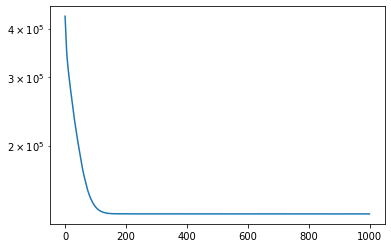

In [8]:
plt.yscale("log")
plt.plot(elbos)

### Test

In [9]:
data = CMAPSSDataModule(args.data_path, batch_size=1)
test_dl = data.test_dataloader()

In [10]:
# Issue with loading state
# bnn.load_state_dict(
#     torch.load(f"{checkpoint_dir}/bnn_state_dict_lr_{num_epochs}_epochs.pt")
# )

In [11]:
error, loglh = 0.0, 0.0
with tyxe.poutine.flipout():
    for x, y in itertools.islice(test_dl, 5):
        #     e, llh = bnn.evaluate(
        #         x.to(DEVICE), y.to(DEVICE), num_predictions=20, reduction="mean"
        #     )
        #     print(e, x.item(), y.item())
        #     error += e
        #     loglh += llh
        m, sd = bnn.predict(x.to(DEVICE), num_predictions=100)
        print(m.item(), sd.item(), y.item())
# error, loglh

101.11054229736328 0.5220259428024292 95.0
101.12276458740234 0.5048713088035583 94.0
101.13169860839844 0.5029587149620056 93.0
101.12968444824219 0.5031689405441284 92.0
101.1171646118164 0.5186139941215515 91.0


In [12]:
error, loglh = 0.0, 0.0
with tyxe.poutine.local_reparameterization():
    for x, y in itertools.islice(test_dl, 5):
        #     e, llh = bnn.evaluate(
        #         x.to(DEVICE), y.to(DEVICE), num_predictions=20, reduction="mean"
        #     )
        #     print(e, x.item(), y.item())
        #     error += e
        #     loglh += llh
        m, sd = bnn.predict(x.to(DEVICE), num_predictions=100)
        print(m.item(), sd.item(), y.item())
# error, loglh

101.119873046875 0.5086914896965027 95.0
101.12389373779297 0.5039412379264832 94.0
101.116455078125 0.5062820911407471 93.0
101.1274185180664 0.5081140995025635 92.0
101.12229919433594 0.5042364597320557 91.0
